In [ ]:
%matplotlib inline

# Face recognition example using eigenfaces and SVMs

In this exercise we'll explore how to extract feature vectors from an image dataset and run PCA and tSNE visualization. We will use a subset of 20 faces from the "Labeled Faces in the Wild" dataset (link below). Each class corresponds to a single person identity and there are 200 images per person, where each image is size 64 x 64. The goal is to find a feature vector that will effectively group images together belonging to the same person class.

You have been provided code that computes PCA and tSNE visualiztion on the raw pixels and histogram of gradients. Add a new feature type, ResNet embedding, and see whether it provides better results.

&nbsp;

Link to dataset:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

&nbsp;

**TODO's**:

1. Add a new feature - ResNet embedding
2. Compute and plot PCA and tSNE for all three features

**Discussion Q's**:
- What is being represented in the ResNet feature vector?
- Are the results for ResNet better than for HOG? Why or why not?


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.datasets import fetch_olivetti_faces
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import urllib
from PIL import Image
from torch import nn
import torchvision.models as models
from torchvision import transforms
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

# load the labeled face in wild dataset from sklearn

In [ ]:
# the min_faces_per_person dictates the number of classes
lfw_people = fetch_olivetti_faces()

# the label to predict is the id of the person
y = lfw_people.target

# keep only 20 classes
lfw_people.images = lfw_people.images[y<20, ...]
y = y[y<20]

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

n_classes = len(np.unique(y))

print("Total dataset size:")
print(f"n_samples, height, width: {n_samples}, {h}, {w}")
print("n_classes: %d" % n_classes)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Total dataset size:
n_samples, height, width: 200, 64, 64
n_classes: 20


# Use a pre-trained model to extract features

In [ ]:
# load the model
resnet101 = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 78.0MB/s]


In [ ]:
# get the network without the classification layer
# Drop the output layer (the ImageNet classifier)

def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])

model_conv_features = slice_model(resnet101, to_layer=-1).to('cpu')
summary(model_conv_features, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# pre-processing required by ResNext
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def retype_image(in_img):
  if np.max(in_img) > 1:
    in_img = in_img.astype(np.uint8)
  else:
    in_img = (in_img * 255.0).astype(np.uint8)
  return in_img

def read_image(in_url):
  # read the image and convert it to PIL image
  out_im = np.array(Image.open(urllib.request.urlopen(in_url)))[:, :, :3]
  out_im = retype_image(out_im)

  # preprocess the image to prepare it for input to CNN
  out_im = preprocess(Image.fromarray(out_im))

  return out_im

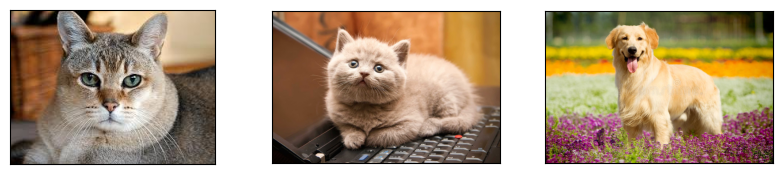

In [ ]:
# downlaod and display some example images
fl = ['https://raw.githubusercontent.com/W281/fileRepository/main/live_session/cat1.png',
      'https://raw.githubusercontent.com/W281/fileRepository/main/live_session/cat2.png',
      'https://raw.githubusercontent.com/W281/fileRepository/main/live_session/dog1.png']

img1_cat = read_image(fl[0])
img2_cat = read_image(fl[1])
img1_dog = read_image(fl[2])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,2))
ax[0].imshow(Image.open(urllib.request.urlopen(fl[0])))
ax[1].imshow(Image.open(urllib.request.urlopen(fl[1])))
ax[2].imshow(Image.open(urllib.request.urlopen(fl[2])))

for axi in ax:
  axi.set_xticks([])
  axi.set_yticks([])
plt.show()

In [ ]:
# put the model in evaluation mode
resnet101.eval()

# extract the embeddings for the three images
emb1_cat = model_conv_features(img1_cat.unsqueeze(0).to('cpu')).squeeze()
print(emb1_cat.shape)

emb2_cat = model_conv_features(img2_cat.unsqueeze(0).to('cpu')).squeeze()
emb1_dog = model_conv_features(img1_dog.unsqueeze(0).to('cpu')).squeeze()

torch.Size([2048])


In [ ]:
# get the cosine similarity between the images
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

cat_cat_sim = cos(emb1_cat.unsqueeze(0), emb2_cat.unsqueeze(0))
print('\n Simlarity between cat images: {0:.4}\n'.format(cat_cat_sim.detach().numpy()[0]))

cat_dog_sim = cos(emb1_cat.unsqueeze(0), emb1_dog.unsqueeze(0))
print('\n Simlarity between cat and dog images: {0:.4}\n'.format(cat_dog_sim.detach().numpy()[0]))


 Simlarity between cat images: 0.7024


 Simlarity between cat and dog images: 0.6002



# extract features from images

In [ ]:
def get_features(in_imgs, feat_name='pixels'):
  featurelist = []
  sample_img = None

  if feat_name == 'pixels':
    # stack flattened images into array

    for i in range (in_imgs.shape[0]):
      featurelist.append(in_imgs[i, :, :].flatten()[np.newaxis, :])
    features = np.vstack(featurelist)
    sample_img = in_imgs[0, :, :]

  if feat_name == 'hog':
    # stack extracted hog features into array
    # also save the first hog image for plotting
    for i in range(in_imgs.shape[0]):
        fd, hog_image = hog(in_imgs[i, :, :], orientations=4, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True, multichannel=False)
        if i == 0:
          sample_img = hog_image
        featurelist.append(fd[np.newaxis, :])

  if feat_name == 'CNN':
    for i in range(in_imgs.shape[0]):

      # convert the grayscale to RGB images
      cur_rgb = np.tile(in_imgs[i, :, :][:, :, np.newaxis], (1, 1, 3))
      cur_rgb = retype_image(cur_rgb)

      # preprocess the image to prepare it for input to CNN
      out_im = preprocess(Image.fromarray(cur_rgb))
      featurelist.append(model_conv_features(out_im.unsqueeze(0).to('cpu')).squeeze().detach().numpy())

      if i==0:
        print('No image for CNN feature')
        print(featurelist[0].shape)

  if sample_img is not None:
    # plot the sample image
    plt.figure(figsize=(5,5))
    plt.imshow(sample_img, cmap='gray')
    plt.axis('off')
    plt.show()

  if featurelist:
    return np.vstack(featurelist)

  return None


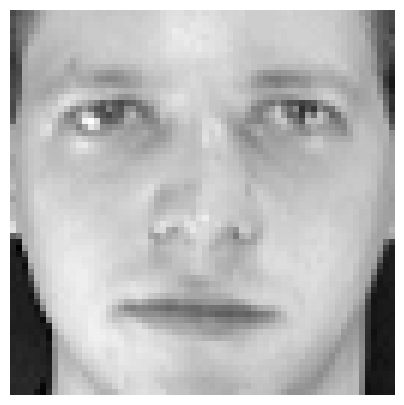

(200, 4096)


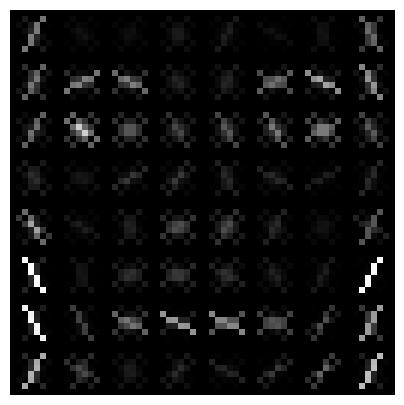

(200, 784)
No image for CNN feature
(2048,)
(200, 2048)


In [ ]:
# plot example features

pixel_features = get_features(lfw_people.images, feat_name='pixels')
print(pixel_features.shape)

hog_features = get_features(lfw_people.images, feat_name='hog')
print(hog_features.shape)

CNN_features = get_features(lfw_people.images, feat_name='CNN')
print(CNN_features.shape)

# dimensionality reduction

In [ ]:
def get_PCA(X_list, n_components=2):
  pca_list = []
  xpca_list = []
  for X in X_list:
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
    X_pca = pca.transform(X)
    pca_list.append(pca)
    xpca_list.append(X_pca)
  return pca_list, xpca_list

def plot_PCA(X_list, n_components=2):
  pca_list, xpca_list = get_PCA(X_list, n_components=n_components)
  plt.figure(figsize=(15,5))
  colors = ['b-', 'm-', 'k-']
  labels = ['pixel features', 'hog features', 'CNN features']
  for i in range(len(X_list)):
    plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
  plt.xticks(np.arange(n_components)+1)
  plt.yticks(np.linspace(0, 1, 8))
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variances')
  plt.legend()
  plt.show()

def get_tsne(X_list, n_components=2):
  xtsne_list = []
  for X in X_list:
    tsne = TSNE(n_components=n_components, random_state=0)
    X_tsne = tsne.fit_transform(X)
    xtsne_list.append(X_tsne)
  return xtsne_list

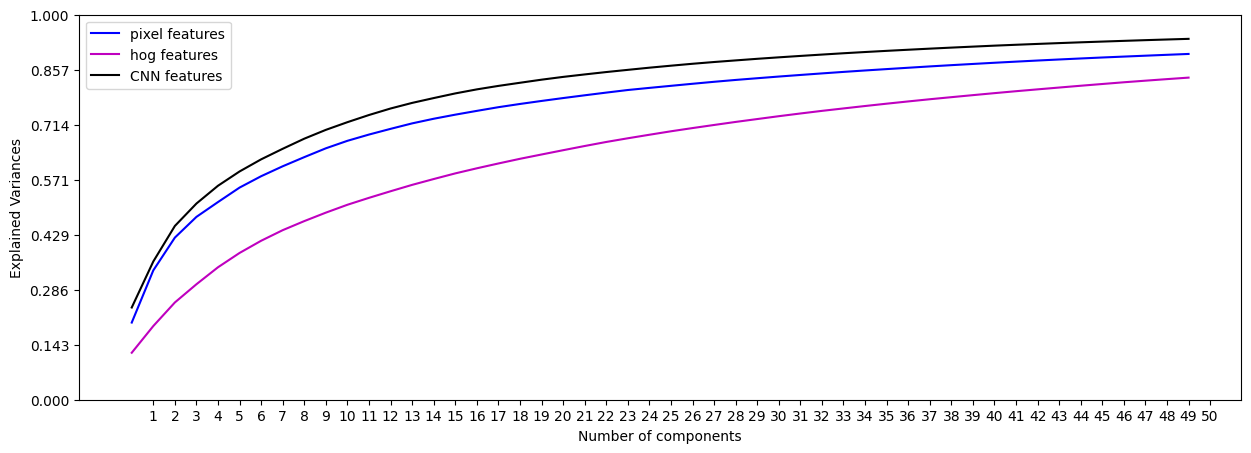

In [ ]:
# plot explained variance vs the number of components for PCA
x = plot_PCA([pixel_features, hog_features, CNN_features], n_components=50)

In [ ]:
# dimensionality reduction
X_pixels_pca, X_hog_pca, X_CNN_pca = get_PCA([pixel_features, hog_features, CNN_features], n_components=2)[-1]
X_pixels_tsne, X_hog_tsne, X_CNN_tsne = get_tsne([pixel_features, hog_features, CNN_features], n_components=2)

# visualize discriminability of features in 2D

In [ ]:
def plot_classes(X, y, ax, title):

  # color code each cluster (person ID)
  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

  # project the features into 2 dimensions
  for k in range(len(np.unique(y))):
    ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k])

  ax.set_title(title)

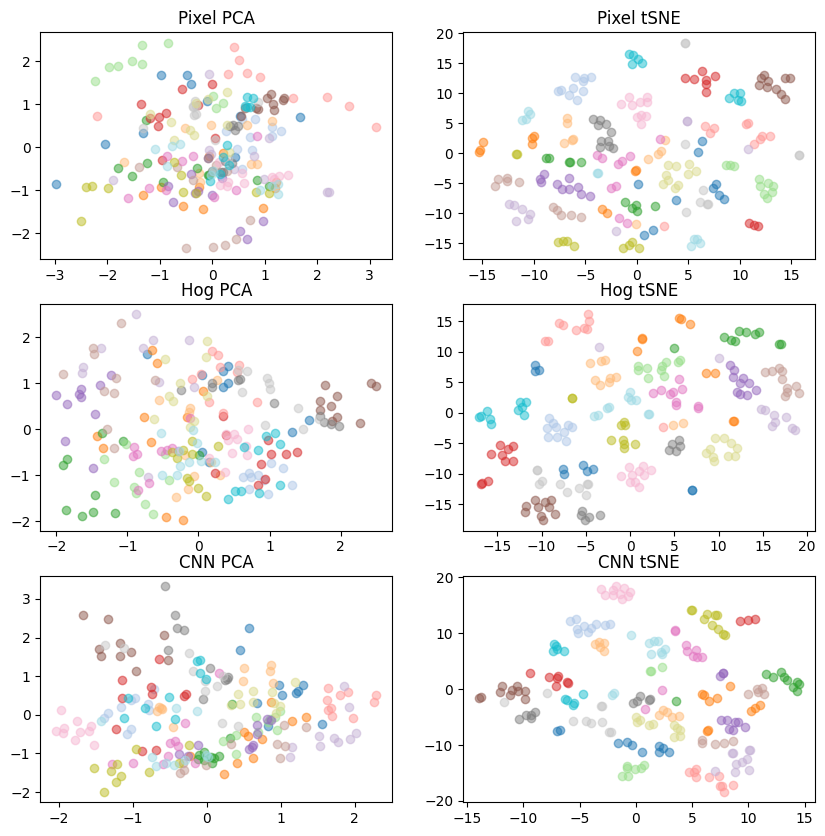

In [ ]:
# plot results
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

# y is the class labels (person ID)
plot_classes( X_pixels_pca, y, ax[0,0], title='Pixel PCA')
plot_classes(X_pixels_tsne, y, ax[0,1], title='Pixel tSNE')

plot_classes( X_hog_pca, y, ax[1,0], title='Hog PCA')
plot_classes(X_hog_tsne, y, ax[1,1], title='Hog tSNE')

plot_classes(X_CNN_pca, y, ax[2,0], title='CNN PCA')
plot_classes(X_CNN_tsne, y, ax[2,1], title='CNN tSNE')

plt.show()